# IA - Trabalho 1 - Aprendizado de Máquina


* Nome: Daniel de Almeida Duque
* Curso: Engenharia de Computação

## Bibliotecas

In [ ]:
# preparation to classify
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# classifiers - first step
from sklearn.utils.validation import check_X_y
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# results
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import ttest_rel as t_test
from scipy.stats import wilcoxon
from scipy import stats

# variety
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import Counter

## Parâmetros Predefinidos

In [ ]:
n_repeats = 3 # number of rounds
n_splits = 10 # number of folds for external test cicle
cv = 4 # number of folds for internal validation cicle

random_state = 36851234 # random state for Repeated Stratified K Fold

# grid search
KMC_gs_param = {'estimator__cx': [KMeans(1), KMeans(3), KMeans(5), KMeans(7)]}
KNN_gs_param = {'estimator__n_neighbors': [1, 3, 5, 7]}
AD_gs_param = {'estimator__max_depth': [None, 3, 5, 10]}

# results
scoring = 'accuracy'
confiance_interval = 0.95 # 95%
alpha = 1 - confiance_interval # 5%

# 10 folds with 3 repeats
rskf = RepeatedStratifiedKFold(n_splits=n_splits, 
                               n_repeats=n_repeats, 
                               random_state=random_state)

# z-score
scaler = StandardScaler()

## Dataset

### Importação dos Dados

Usando dataset do sklearn

In [ ]:
df = datasets.load_wine(as_frame=True).frame

X, y = datasets.load_wine(return_X_y=True)
_, features = X.shape

target_names = datasets.load_wine().target_names
X[:3], y[:3]

(array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
         3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, 1.000e+02, 2.650e+00,
         2.760e+00, 2.600e-01, 1.280e+00, 4.380e+00, 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00,
         3.240e+00, 3.000e-01, 2.810e+00, 5.680e+00, 1.030e+00, 3.170e+00,
         1.185e+03]]), array([0, 0, 0]))

Usando dataset próprio

In [ ]:
# df_input = pd.read_csv('fviii_point_missense_mutation_database.csv')
# df_input.head()

# sev_to_int = {'Mild': 0,
#               'Moderate': 1,
#               'Severe': 2}

# X = np.array([list(i) for i in zip(df_input.dist_aa.values, df_input.rsa.values)])
# y = np.array([sev_to_int[i] for i in list(df_input.severity.values)])

# data = pd.DataFrame(X, columns = ['dist_aa','rsa'])
# X[:3], y[:3]

### Exploração dos Dados

Explorando o banco de dados para escrever informações relevantes no artigo

In [ ]:
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


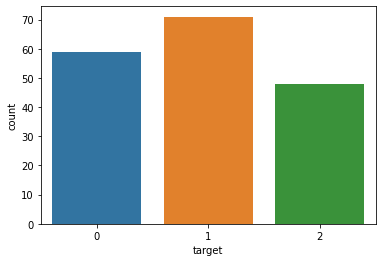

In [ ]:
sns.countplot(data=df, x='target');

* 3 classes: 0, 1 ou 2;

In [ ]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [ ]:
df_describe = df.describe()
df_describe = df_describe.applymap(lambda x: f'{x:.2f}')

with pd.ExcelWriter('describe_table.xlsx') as writer:
  df_describe.to_excel(writer, sheet_name='sheet_1')

## Classificação

### 1º Etapa - ZR e NBG

* Classificadores ZR e NBG não possuem hiperparâmetros.

* Treino e teste - Validação Cruzada Estratificada:
  * 3 rodadas de validação cruzada estratificada;
  * 10 folds - ciclo de teste.

* Padronizar o conjunto de treino em cada rodada de teste utilizando normalização com z-score e utilizar os valores obtidos para padronizar os dados do respectivo conjunto de teste.

In [ ]:
def first_step(estimator):
  # padroniza com z-score e executa classificacao com ZR ou NBG
  pipeline = Pipeline([('scaler', scaler), ('estimator', estimator)])

  scores = []
  for train_index, test_index in rskf.split(X, y):
    # divide em X e y em treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # padroniza e treina o classificador
    pipeline.fit(X_train, y_train)
    # padroniza e calcula score
    s = pipeline.score(X_test, y_test)
    scores.append(s)
  
  scores = np.array(scores)
  return scores

### 2º Etapa - KMC, KNN e AD

* Treino, validação e teste:
  * 3 rodadas de ciclos aninhados de validação e teste;
  * 4 folds - ciclo interno de validação;
  * 10 folds - ciclo externo de teste.

* Padronizar o conjunto de treino em cada rodada de teste utilizando normalização com z-score e utilizar os valores obtidos para padronizar os dados do respectivo conjunto de teste.

In [ ]:
def second_step(estimator, param_grid):
  # padroniza com z-score e executa classificacao com KMC, KNN ou AD
  pipeline = Pipeline([('scaler', scaler), ('estimator', estimator)])  

  # gridsearch com os parametros definidos nas especificações
  gs = GridSearchCV(estimator = pipeline,
                    param_grid = param_grid,
                    scoring = scoring,
                    cv = cv)
  
  # scores com base no gridsearch
  scores = cross_val_score(estimator = gs,
                           X = X,
                           y = y,
                           scoring = scoring,
                           cv = rskf)
  
  scores = np.array(scores)
  return scores

### KMC

#### Preparação

Implementação de todas funções para executar o KMC

Forma K grupos para 1 classe

In [ ]:
def group_by(elements, labels):
  # pega as keys com base nos labels
  keys = np.unique(labels)
  # dicionário com key = label e value = lista de elementos do mesmo label
  d = {key: [] for key in keys}
  # agrupa os elementos de mesmo label
  for i in range(len(elements)):
    k = labels[i]
    v = elements[i]
    d[k].append(v)
  # converte a lista de elementos para numpy array
  for k, v in d.items():
    d[k] = np.array(np.stack(v, axis=0))
  
  return d

In [ ]:
def k_group_by(elements, kmeans):
  # agrupa os elementos com respectivos labels definido pelo agrupamento kmeans
  kmeans.fit(elements)
  labels = kmeans.labels_  
  k_groups = group_by(elements=elements, labels=labels)
  
  return k_groups

Forma K grupos para ncl classes

In [ ]:
def kmc_init_k_ncl_groups(X, y, kmeans):
  # cria os grupos das classes
  k_ncl_groups = group_by(X, y)
  # cria os K grupos para cada classe
  for k, v in k_ncl_groups.items():
    k_ncl_groups[k] = k_group_by(v, kmeans)

  return k_ncl_groups

In [ ]:
# o algoritmo KMC forma inicialmente K*ncl grupos, sendo K grupos em cada uma das ncl classes.
kmc_init = kmc_init_k_ncl_groups(X, y, KMeans(n_clusters=3))

Calcula centróide para 1 grupo

In [ ]:
def calculate_centroid(nd_array):
  # num_col - numero de colunas
  _, num_col = nd_array.shape
  # centroide = conjuntos das medianas das colunas do array n dimensional
  centroid = []
  for col_index in range(num_col):
    # pega uma coluna
    col_array = nd_array[:,col_index]
    # calcula a mediana da coluna
    col_median = round(np.median(col_array), 3)
    # adiciona mediana da coluna no centroid
    centroid.append(col_median)

  return centroid

Calcula centróide para K*ncl grupos

In [ ]:
def calculate_centroid_each_group(k_ncl_groups):
  # calcula centroide para todos K*ncl grupos
  list_class_centroid = []
  for classe, groups in k_ncl_groups.items():
    for _, group in groups.items():
      # calcula centroide de um grupo
      group_centroid = calculate_centroid(group)
      # faz tupla com a classe e seu centroide
      list_class_centroid.append((classe, group_centroid))

  return list_class_centroid 

In [ ]:
# calcula os centróides de cada um dos grupos e este centróide é associado a classe do grupo a partir do qual foi gerado
kmc_centroids = calculate_centroid_each_group(kmc_init)
kmc_centroids

[(0,
  [13.48,
   1.9,
   2.56,
   17.5,
   110.0,
   2.7,
   2.97,
   0.28,
   1.86,
   4.6,
   1.04,
   3.38,
   830.0]),
 (0,
  [13.885,
   1.745,
   2.49,
   17.05,
   107.0,
   2.915,
   3.165,
   0.295,
   1.96,
   6.1,
   1.125,
   2.89,
   1292.5]),
 (0,
  [13.78,
   1.73,
   2.375,
   16.2,
   101.0,
   2.8,
   2.93,
   0.275,
   1.86,
   5.32,
   1.04,
   3.21,
   1062.5]),
 (1,
  [12.29,
   1.63,
   2.24,
   20.8,
   87.0,
   2.2,
   2.09,
   0.37,
   1.62,
   2.9,
   0.98,
   2.87,
   428.0]),
 (1,
  [12.38,
   1.565,
   2.255,
   20.7,
   121.0,
   2.9,
   2.205,
   0.265,
   1.805,
   3.13,
   1.075,
   2.88,
   911.5]),
 (1,
  [12.08,
   1.51,
   2.29,
   19.25,
   94.0,
   2.1,
   1.77,
   0.335,
   1.44,
   2.92,
   1.05,
   2.77,
   645.0]),
 (2,
  [12.96,
   3.24,
   2.38,
   21.0,
   96.0,
   1.7,
   0.68,
   0.5,
   1.03,
   7.65,
   0.7,
   1.68,
   650.0]),
 (2,
  [13.095,
   3.43,
   2.39,
   21.75,
   96.0,
   1.515,
   0.78,
   0.475,
   1.03,
   6.16,
   0.63

Centroid mais próximo de 1 elemento

In [ ]:
def class_of_closer_centroid(element, class_centroids):
  # retorna a classe do centroide mais perto
  min_tup = (1_000_000, 1_000_000, 1_000_000)  
  for classe, centroid in class_centroids:
    # pega a menor distancia
    _, _, min_dist = min_tup
    # calcula distancia do elemento ao centroide
    dist = distance.euclidean(centroid, element)
    # se a distancia atual for menor do que menor, muda a menor distancia
    if dist < min_dist:
      min_tup = (element, (classe, centroid), dist)
  
  # pega a classe do menor centroide
  _, closer_class_centroid, _ = min_tup
  return closer_class_centroid

In [ ]:
# associa o elemento com a classe do centroide mais perto

class_element, _ = class_of_closer_centroid(list(range(0, features)), kmc_centroids)
class_element

1

Centroid mais próximo de todos elementos

In [ ]:
def class_of_closer_centroid_each_element(elements, class_centroids):
  # ver centroide mais proximo de cada elemento e classifica conforme a classe
  y_pred = []
  for element in elements:
    # centroide mais proximo de um elemento
    class_element, _ = class_of_closer_centroid(element, class_centroids)
    # adiciona na lista que e o y predito 
    y_pred.append(class_element)
  
  # numpy array que ja e o y predito
  y_pred = np.array(y_pred)
  return y_pred

In [ ]:
class_of_closer_centroid_each_element(X, kmc_centroids)

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2,
       2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0,
       0, 2])

#### Definição

Definição do classificador KMC usando o KMeans como BaseEstimator

In [ ]:
class KMCClassifier(BaseEstimator):
  def __init__(self, cx=None, cy=None):
    super().__init__()
    self.cx = cx
    self.cy = cy

  def fit(self, x_train, y_train):
    x_train, y_train = check_X_y(x_train, y_train)
    # cria os K*ncl grupos iniciais
    kmc_init = kmc_init_k_ncl_groups(x_train, y_train, self.cx)
    # calcula os centroides para os K*ncl grupos e associa as respectivas classes
    class_centroids = calculate_centroid_each_group(kmc_init)

    # guarda os centroides com suas classes para usar na predicao
    self.__self_pred = class_centroids

  def predict(self, x_test):
    # verifica o centroide mais próximo para cada elemento do vetor e associa a classe
    y_pred = class_of_closer_centroid_each_element(x_test, self.__self_pred)
    # retorna o y predito usando KMC
    return y_pred

In [ ]:
kmc = KMCClassifier(KMeans(n_clusters=3))
kmc.fit(X, y)
y_pred = kmc.predict(X)

report = classification_report(y, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        59
           1       0.68      0.59      0.63        71
           2       0.50      0.65      0.56        48

    accuracy                           0.69       178
   macro avg       0.69      0.69      0.69       178
weighted avg       0.71      0.69      0.69       178



## Execução dos Classificadores

Execução e cálculo do score de todos classificadores

In [ ]:
dict_scores = {}

# 1º step
ZR = DummyClassifier()
NBG = GaussianNB()

ZR_scores = first_step(ZR)
NBG_scores = first_step(NBG)

dict_scores['ZR'] = ZR_scores
dict_scores['NBG'] = NBG_scores

# 2º step
KMC = KMCClassifier(KMeans())
KNN = KNeighborsClassifier()
AD = DecisionTreeClassifier()

KMC_scores = second_step(KMC, KMC_gs_param)
KNN_scores = second_step(KNN, KNN_gs_param)
AD_scores = second_step(AD, AD_gs_param)

dict_scores['KMC'] = KMC_scores
dict_scores['KNN'] = KNN_scores
dict_scores['AD'] = AD_scores

In [ ]:
dict_scores

{'AD': array([0.94444444, 1.        , 0.83333333, 0.88888889, 0.83333333,
        0.94444444, 0.94444444, 0.94444444, 0.94117647, 0.88235294,
        0.94444444, 1.        , 0.94444444, 1.        , 0.94444444,
        0.72222222, 0.94444444, 0.88888889, 1.        , 0.88235294,
        0.94444444, 0.83333333, 0.94444444, 0.88888889, 0.88888889,
        0.83333333, 0.94444444, 0.83333333, 0.94117647, 1.        ]),
 'KMC': array([1.        , 0.94444444, 0.94444444, 0.94444444, 0.94444444,
        0.94444444, 1.        , 1.        , 1.        , 0.82352941,
        0.94444444, 1.        , 1.        , 1.        , 0.94444444,
        0.77777778, 0.94444444, 1.        , 1.        , 0.88235294,
        0.94444444, 1.        , 1.        , 0.94444444, 0.94444444,
        1.        , 0.88888889, 0.94444444, 0.94117647, 1.        ]),
 'KNN': array([1.        , 1.        , 1.        , 0.94444444, 0.94444444,
        0.94444444, 1.        , 0.94444444, 1.        , 0.82352941,
        0.94444444, 0.94

## Análise dos Resultados

### Boxplots

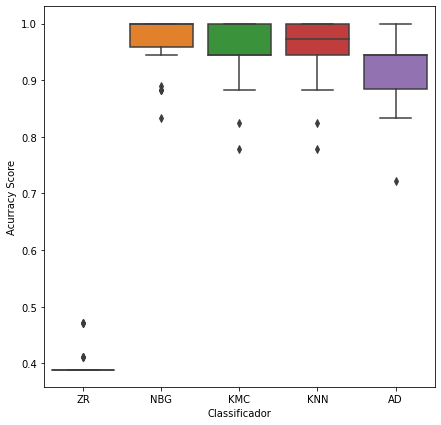

In [ ]:
df = pd.DataFrame(dict_scores)

fig, axes = plt.subplots(figsize=(7, 7))
sns.boxplot(data=df.loc[:,:])
axes.set_xlabel('Classificador')
axes.set_ylabel('Acurracy Score')

plt.savefig('accuracy_boxplot.pdf')

### Tabela de acurácia

Faz a tabela de acurácia como um dataframe

In [ ]:
def results_accuracy(scores):
  mean = scores.mean()
  std = scores.std()
  inf, sup = stats.norm.interval(confiance_interval,
                                 loc=mean,
                                 scale=std/np.sqrt(len(scores)))
  
  return {'media': mean,
          'desvio_padrao': std,
          'limite_inferior': inf,
          'limite_superior': sup}

In [ ]:
def table_accuracy(scores):
  d = {k:results_accuracy(v) for k, v in scores.items()}
  df = pd.DataFrame(d).T
  # arredonda os valores para 2 casas decimais
  df = df.applymap(lambda x: f'{x:.2f}')

  return df

In [ ]:
df_acc = table_accuracy(dict_scores)
df_acc

,media,desvio_padrao,limite_inferior,limite_superior
ZR,0.40,0.02,0.39,0.41
NBG,0.97,0.05,0.96,0.99
KMC,0.95,0.05,0.94,0.97
KNN,0.96,0.05,0.94,0.98
AD,0.92,0.06,0.89,0.94


In [ ]:
with pd.ExcelWriter('accuracy_table.xlsx') as writer:
  df_acc.to_excel(writer, sheet_name='sheet_1')

### Tabela pareada dos resultados (p-values)

Faz a tabela pareada dos p-values como um dataframe

In [ ]:
def results_paired(scores1, scores2):
  _, p_value_t = t_test(scores1, scores2)
  _, p_value_w = wilcoxon(scores1, scores2)

  return p_value_t, p_value_w

In [ ]:
def table_paired(scores):
  # lista as keys para facilitar manipulacao
  keys = list(scores.keys())
  # quantidade de keys para criar tamanho da matriz
  size = len(keys)
  # matrix que eh a tabela pareada
  matrix_hyp = np.zeros((size, size))
  
  # faz a tabela pareada
  for i in range(size):
    k1 = keys[i]
    s1 = scores[k1]
    for j in range(size):
      k2 = keys[j]
      s2 = scores[k2]
      # diagonal vai ficar o nome do classificador
      if k1 == k2:
        matrix_hyp[i][j] = np.NaN
      # nao diagonal vai ficar os p-values dos testes pareados
      else:
        t, w = results_paired(s1, s2)
        # triangular superior = p-value do t-pareado
        matrix_hyp[i][j] = t
        # triangular inferior = p-value do wilcoxon
        matrix_hyp[j][i] = w
    
  # transforma a matriz em um dataframe para facilitar manipulacao
  df = pd.DataFrame(matrix_hyp, index = keys, columns = keys)
  # arredonda os valores para 3 casas decimais
  df = df.applymap(lambda x: f'{x:.3e}' if x < 0.0001 else f'{x:.3f}')
  # transforma os valores para string para poder manipular
  df = df.astype(str)
  # coloca a diagonal do dataframe com os respectivos nomes dos classificadores
  df.at['ZR','ZR'] = 'ZR'
  df.at['NBG','NBG'] = 'NBG'
  df.at['KMC','KMC'] = 'KMC'
  df.at['KNN','KNN'] = 'KNN'
  df.at['AD','AD'] = 'AD'

  # coloca em negrito quando p-value < 0.05
  def apply_bold(txt):
    try:
      bold = 'bold' if float(txt) < alpha else ''
      return 'font-weight: %s' % bold
    except:
      None
  
  # aplica o negrito no estilo do dataframe
  df_style = df.style.applymap(apply_bold)

  return df, df_style

In [ ]:
df_paired, df_style_paired = table_paired(dict_scores)
df_style_paired

,ZR,NBG,KMC,KNN,AD
ZR,ZR,8.057e-07,1.295e-06,1.249e-06,1.470e-06
NBG,1.143e-29,NBG,0.043,0.115,0.000
KMC,1.180e-28,0.016,KMC,0.405,0.004
KNN,1.130e-28,0.053,0.415,KNN,0.001
AD,1.606e-27,1.313e-06,0.001,0.000,AD


In [ ]:
with pd.ExcelWriter('paired_table.xlsx') as writer:
  df_paired.to_excel(writer, sheet_name='sheet_1')


## Referências

Disponiblizado pelo professor

* https://scikit-learn.org/stable/datasets/toy_dataset.html

* https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Pesquisa pelo aluno

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

* https://seaborn.pydata.org/generated/seaborn.boxplot.html

* https://docs.scipy.org/doc/scipy/reference/stats.html
